<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: [FULL_NAME]</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: [STUDENT_ID]</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [9]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [10]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [11]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** Agents might perform differently; for example, in skewed distributions, agents that rely on exploration may struggle to identify the best arm if the high-probability arm is rarely sampled.


In [12]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** The binary reward simplifies analysis and allows focus on the exploration/exploitation trade-off without the added complexity of variable reward magnitudes.

In [13]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [14]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [16]:
# %% [code] Solution Version
# The maximum expected reward per step is the max probability.
oracleReward = np.max(p_arr)
print(f'Max possible reward (Solution): {oracleReward}')

Max possible reward (Solution): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** It sets an upper bound for performance. No realistic agent can exceed this bound, so it helps measure the regret of other algorithms.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** Because it has access to privileged information (i.e., the true probabilities), which is not available in real-world scenarios.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [17]:
# %% [code] Solution Version
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # Random agent does not update

    def get_action(self):
        self.t += 1
        # Choose uniformly at random from available actions
        sel_act = np.random.choice(self.n_act)
        return sel_act

In [18]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


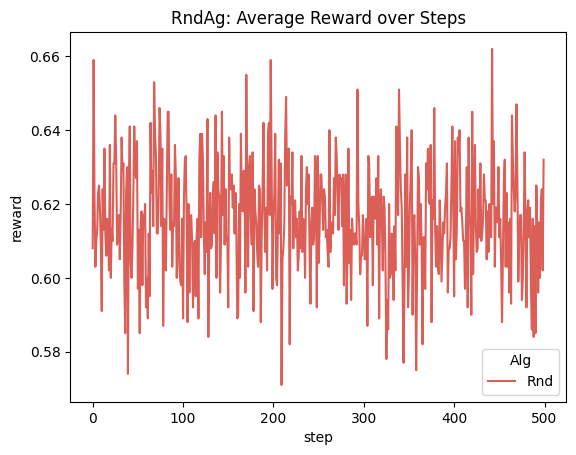

In [19]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** Because it selects arms without learning or optimizing, so its performance fluctuates with chance and it often misses the high-reward arms.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** You could incorporate a simple heuristic (e.g., use prior knowledge about arm distributions) to bias the random selection, though it still wouldn’t learn from outcomes.

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


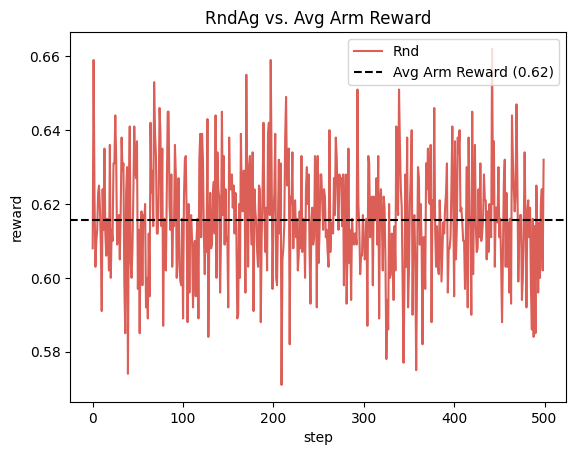

In [20]:
# %% [code] Solution Version
# Plot RndAg reward curve
ax = plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
# Plot the average reward of all arms as a horizontal line
avg_rew = np.mean(p_arr)
plt.axhline(y=avg_rew, color='black', linestyle='--', label=f'Avg Arm Reward ({avg_rew:.2f})')
plt.legend()
plt.title("RndAg vs. Avg Arm Reward")
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [21]:
# %% [code] Solution Version
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental update: new Q = old Q + (1/count)*(rew - old Q)
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        if self.t <= self.max_ex:
            # Explore: choose random action
            sel_act = np.random.choice(self.n_act)
        else:
            # Exploit: choose action with highest Q value (break ties arbitrarily)
            sel_act = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


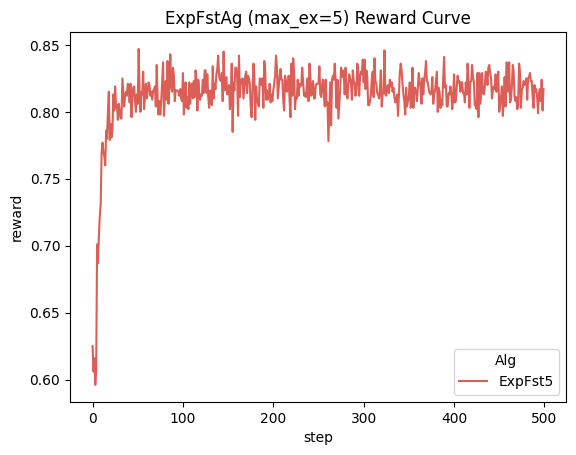

In [22]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** With very few samples, the estimate of each arm’s reward is noisy and unstable, causing high variance and fluctuating performance.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** A fixed phase might not sample all arms adequately if the phase is too short, or it might waste time if too long, delaying exploitation of the best arm.


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


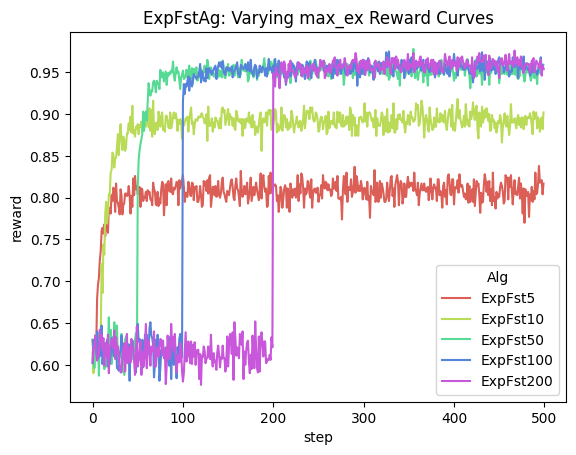

In [24]:
# %% [code] Solution Version
max_ex_list = [5, 10, 50, 100, 200]
logs_list = []
for ex in max_ex_list:
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log_df = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    logs_list.append(log_df)
all_exp_logs = pd.concat(logs_list, ignore_index=True)

plot_logs(all_exp_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg: Varying max_ex Reward Curves")
plt.show()

**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** Increasing `max_ex` gives the agent more time to learn the best arm, leading to a more accurate estimate, but can also delay exploitation and slow overall cumulative reward.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** The optimal duration is problem-dependent and may vary over time; a fixed value might not adapt well to changes in the environment, suggesting the need for adaptive strategies.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [26]:
# %% [code] Solution Version
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental update
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        delta = 1e-5
        bonus = np.array([np.sqrt(2 * np.log(self.t + 1) / (self.act_counts[a] + delta))
                          for a in range(self.n_act)])
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


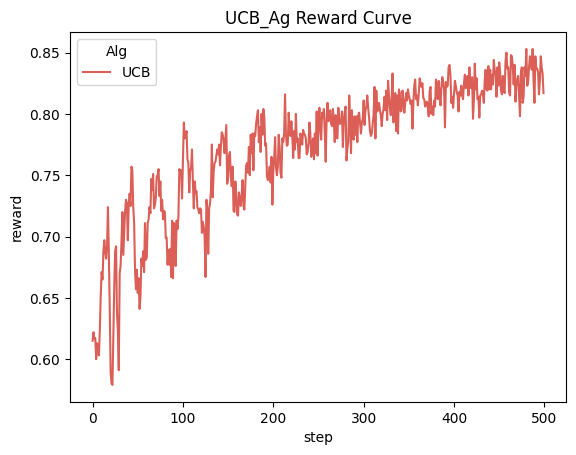

In [28]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.


UCB algorithm can learn slowly because it heavily explores uncertain actions, especially early on. It balances estimated rewards with confidence bounds, which may cause prolonged sampling of suboptimal arms in environments with many similar options or high reward variance. This slows convergence and delays optimal performance, even after many steps.


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


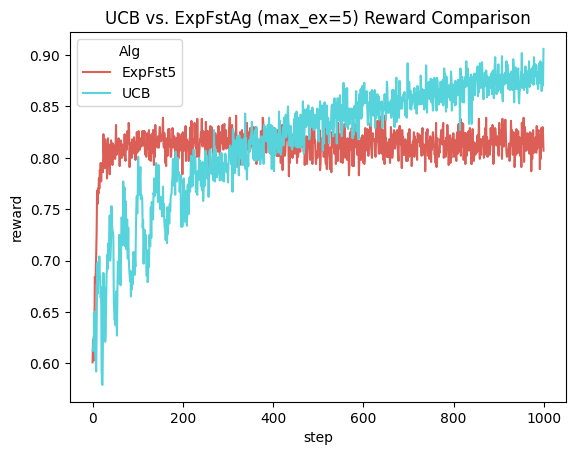

In [30]:
# %% [code] Solution Version
# Instantiate both agents
expfst_agent_5 = ExpFstAg(n_act=len(p_arr), max_ex=5)
ucb_agent = UCB_Ag(n_act=len(p_arr))

# Run experiments for 1000 runs and 1000 steps
log_expfst5 = mab_swp([expfst_agent_5], p_arr, ['ExpFst5'], n_runs=1000, max_steps=1000)
log_ucb = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=1000)

# Concatenate logs and plot
comp_log = pd.concat([log_expfst5, log_ucb], ignore_index=True)
plot_logs(comp_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=5) Reward Comparison")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** In finite time horizons or when exploration duration is well-tuned, explore-first can quickly latch onto a high-reward arm, whereas UCB’s cautious approach might slow down overall reward accumulation.

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** Explore-first may perform better short-term if the exploration phase is adequate, while UCB is designed to be asymptotically optimal but might lag in early performance.


**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Letting ExpFstAg explore for 20 steps means its success depends on how accurate its early estimates are. Poor exploration can lead to choosing a suboptimal arm and lower overall reward. In contrast, UCB continually balances exploration and exploitation, adapting to uncertainty over time. This often results in better cumulative rewards than ExpFstAg, especially in longer runs.


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


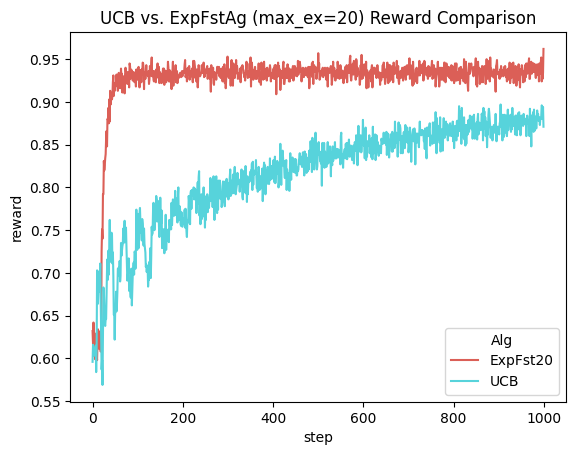

In [31]:
# %% [code] Solution Version
# Instantiate ExpFstAg with 20 exploration steps
expfst_agent_20 = ExpFstAg(n_act=len(p_arr), max_ex=20)
ucb_agent = UCB_Ag(n_act=len(p_arr))

# Run experiments for 1000 runs and 1000 steps
log_expfst20 = mab_swp([expfst_agent_20], p_arr, ['ExpFst20'], n_runs=1000, max_steps=1000)
log_ucb = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=1000)

# Concatenate and plot
comp_log2 = pd.concat([log_expfst20, log_ucb], ignore_index=True)
plot_logs(comp_log2, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=20) Reward Comparison")
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** It allows more accurate estimation of arm rewards, reducing early variability, but delays exploitation which might lower cumulative reward if exploration goes on too long.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** By conducting experiments, using cross-validation, or employing adaptive methods that adjust the exploration rate based on real-time performance metrics.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** UCB is provably optimal in the asymptotic sense, its conservative exploration strategy can lead to suboptimal performance in finite-sample settings. ExpFstAg, by contrast, may employ a more aggressive or adaptive exploration mechanism that quickly narrows down promising actions, thereby reducing wasted trials on clearly inferior options. This often results in lower empirical regret on practical time scales, as the algorithm efficiently balances exploration and exploitation in real-world scenarios where the theoretical worst-case guarantees of UCB are less relevant.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


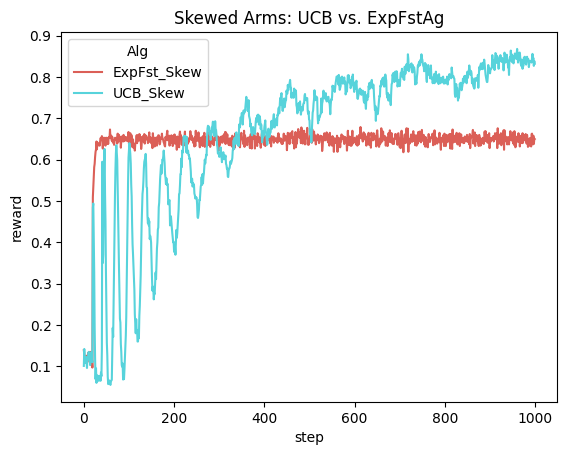

In [33]:
# %% [code] Solution Version
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# Set max_ex to number of arms
expfst_skew_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))
ucb_skew_agent = UCB_Ag(n_act=len(skewed_p))

# Run experiments in the skewed scenario
log_expfst_skew = mab_swp([expfst_skew_agent], skewed_p, ['ExpFst_Skew'], n_runs=1000, max_steps=1000)
log_ucb_skew = mab_swp([ucb_skew_agent], skewed_p, ['UCB_Skew'], n_runs=1000, max_steps=1000)

# Concatenate and plot
skew_log = pd.concat([log_expfst_skew, log_ucb_skew], ignore_index=True)
plot_logs(skew_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Skewed Arms: UCB vs. ExpFstAg")
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [34]:
# %% [code] Solution Version
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        if np.random.rand() < self.eps:
            # Explore: choose random action
            sel_act = np.random.choice(self.n_act)
        else:
            # Exploit: choose best action (with tie-breaker)
            sel_act = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** Because a higher ε means more random (exploratory) actions, which can result in selecting suboptimal arms more frequently.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** Decaying ε allows the agent to explore early on when uncertainty is high and gradually shift towards exploitation as the agent’s estimates become more reliable.


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


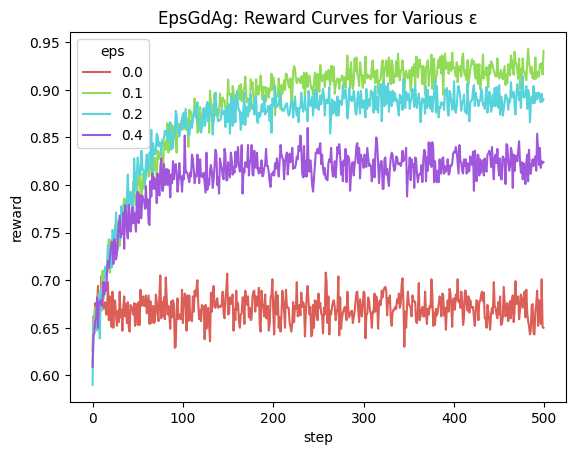

In [35]:
# %% [code] Solution Version
eps_vals = [0, 0.1, 0.2, 0.4]
eps_logs = []
for eps in eps_vals:
    agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    log_df = mab_swp([agent], p_arr, [f'Eps_{eps}'], n_runs=1000, max_steps=500)
    log_df['eps'] = eps
    eps_logs.append(log_df)
all_eps_logs = pd.concat(eps_logs, ignore_index=True)

plot_logs(all_eps_logs, x_key='step', y_key='reward', legend_key='eps', estimator='mean', ci=None)
plt.title("EpsGdAg: Reward Curves for Various ε")
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** Lower ε values show more stable, higher rewards as the agent exploits learned knowledge, whereas higher ε values exhibit more variability and lower cumulative rewards due to excessive exploration.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** In highly dynamic environments where constant adaptation is needed, a higher ε ensures continuous exploration to adjust to changes.


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [36]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [37]:
# %% [code] Solution Version
ctxData = np.loadtxt('dataset.txt')
print("Dataset shape (Solution):", ctxData.shape)

Dataset shape (Solution): (10000, 102)


In [38]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        # If the selected action matches the logged action, return the reward; else None.
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [39]:
# %% [code] Solution Version
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        # state is a feature vector of shape (feat_dim,)
        x = np.array(state).reshape(-1, 1)
        A_inv = np.linalg.inv(self.As[a])
        theta = A_inv @ self.bs[a]
        p = (theta.T @ x)[0, 0] + self.alpha * np.sqrt((x.T @ A_inv @ x)[0, 0])
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        x = np.array(state).reshape(-1, 1)
        self.As[a] += x @ x.T
        self.bs[a] += rew * x

    def get_action(self, state):
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        # Choose arm with maximum estimated UCB (ties broken arbitrarily)
        sel_act = np.random.choice(np.flatnonzero(np.array(p_est) == np.array(p_est).max()))
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** LinUCB uses the context features to estimate expected rewards with a linear model, which can provide more tailored decisions when context correlates with reward.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** The α parameter scales the confidence interval; a higher α encourages more exploration by increasing the bonus, while a lower α emphasizes exploitation based on current estimates.

In [40]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [41]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)

In [42]:
# %% [code] Solution Version
alphas = [0, 0.01, 0.1, 0.5]
logs_ctx = ctxBnd_swp(alphas, ctxData, n_runs=1)

Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-10-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


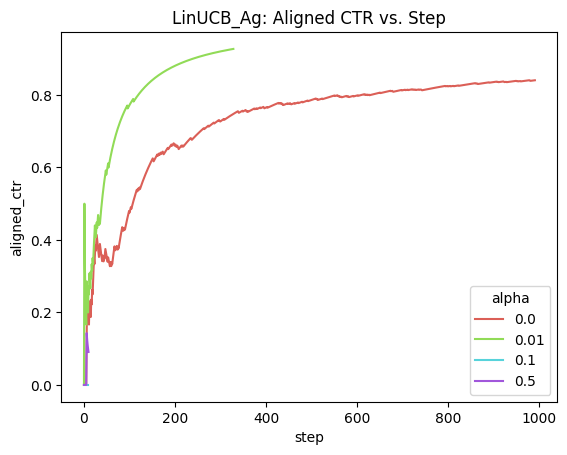

In [43]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** α directly scales the uncertainty term in the upper confidence bound, which modulates the exploration-exploitation trade-off. A larger α enlarges the confidence interval, pushing the algorithm to explore actions with high uncertainty—even if their estimated rewards are lower—while a smaller α tightens the interval, leading to a focus on exploiting actions with high current estimates. This parameter is critical in determining how aggressively the algorithm searches for potentially better actions versus relying on known performance.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** The effect of α on reward curves depends on its role in the algorithm. If α directly scales the reward signal, then the curves will shift accordingly since the absolute magnitude of rewards changes. However, if α only adjusts the learning dynamics—say, by modulating the update rate without altering the inherent reward values—the shape of the reward curve remains the same, although the speed of convergence or the variance along the curve might differ. In essence, whether the reward curves change with α hinges on whether α modifies the reward structure or simply influences how quickly the algorithm learns from the same rewards.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** Answers may vary, but a typical answer is that LinUCB can outperform standard UCB when the context is informative because it personalizes decisions; however, if the context is noisy, its advantage may diminish.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** UCB is simple and parameter-free but may converge slowly, while LinUCB requires context and proper tuning of α. The choice depends on the availability of side information and the time horizon of the problem.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.




## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.


## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.


## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.


## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.


## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.


##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.